# <span style ='color:orange'>Imports

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import shap

%reload_ext autoreload
%autoreload 2

from data_boxscore.data import load_dataframes, custom_query_df
from data_boxscore.xai import shap_query
from data_boxscore.constants import  features_minmax, features_no_scaling, features_perc, features_robust, features_standard
from data_boxscore.plots import create_spider_chart

# <span style ='color:blue'>Loading data

In [32]:
team = "Villeneuve d'Ascq LM"
league = None
season = None

excluded_columns = ['A_score', 'H_score', 'A_FGM', 'H_FGM',
       'A_FGA', 'H_FGA', 'A_FG%', 'H_FG%', 'A_2FGM', 'H_2FGM', 'A_2FGA',
       'H_2FGA', 'A_2FG%', 'H_2FG%', 'A_3FGM', 'H_3FGM', 'A_3FGA', 'H_3FGA',
       'A_3FG%', 'H_3FG%', 'A_FTM', 'H_FTM', 'A_FTA', 'H_FTA', 'A_FT%',
       'H_FT%', 'A_OREB', 'H_OREB', 'A_DREB', 'H_DREB', 'A_TREB', 'H_TREB',
       'A_AST', 'H_AST', 'A_PF', 'H_PF', 'A_TO', 'H_TO', 'A_ST', 'H_ST',
       'A_BLF', 'H_BLF', 'A_plus-minus', 'H_plus-minus', 'A_efficiency',
       'H_efficiency', 'diff_score', 'ELO_diff_before']

In [33]:
gdf, X_train, y_train, X_val, y_val, X_test, y_test, X_query, y_query = load_dataframes(filename='bball.csv',
                                                                    features_standard = features_standard, 
                                                                    features_minmax = features_minmax, 
                                                                    features_robust = features_robust, 
                                                                    features_perc = features_perc,
                                                                    features_no_scaling = features_no_scaling,              
                                                                    use_ELO = True,
                                                                    k_elo = 20,
                                                                    excluded_columns=excluded_columns,
                                                                    team=team,
                                                                    season=season,
                                                                    league=league)
print(gdf.shape, X_train.shape, X_val.shape ,X_test.shape, )
gdf['home_win'].mean()

(840, 58) (504, 6) (126, 6) (126, 6)


0.6

In [34]:
gdf.head(5)

,away_team,home_team,A_score,H_score,A_FGM,H_FGM,A_FGA,H_FGA,A_FG%,H_FG%,...,H_eFG%,A_eFG%,H_OREB%,A_OREB%,H_TOV%,A_TOV%,diff_score,home_win,ELO_diff_before,split
game_id,,,,,,,,,,,,,,,,,,,,,
0,CCC Polkowice,Pieštanské Cajky,71,46,24,14,54,49,0.444444,0.285714,...,0.326531,0.509259,0.216216,0.264706,0.236097,0.201918,-25,False,0.0,0
1,Pieštanské Cajky,CCC Polkowice,60,76,24,27,65,53,0.369231,0.509434,...,0.584906,0.407692,0.230769,0.300000,0.230651,0.180549,16,True,20.0,0
2,BLMA,KSC Szekszard,79,80,29,28,48,59,0.604167,0.474576,...,0.550847,0.625000,0.382353,0.363636,0.199437,0.227638,1,True,0.0,0
3,KSC Szekszard,BLMA,71,86,26,30,58,56,0.448276,0.535714,...,0.598214,0.534483,0.400000,0.322581,0.234632,0.242718,15,True,-20.0,0
4,Galatasaray,Sopron Basket,55,72,23,29,71,58,0.323944,0.500000,...,0.517241,0.345070,0.357143,0.224490,0.270880,0.165125,17,True,0.0,0


In [35]:
gdf.columns

Index(['away_team', 'home_team', 'A_score', 'H_score', 'A_FGM', 'H_FGM',
       'A_FGA', 'H_FGA', 'A_FG%', 'H_FG%', 'A_2FGM', 'H_2FGM', 'A_2FGA',
       'H_2FGA', 'A_2FG%', 'H_2FG%', 'A_3FGM', 'H_3FGM', 'A_3FGA', 'H_3FGA',
       'A_3FG%', 'H_3FG%', 'A_FTM', 'H_FTM', 'A_FTA', 'H_FTA', 'A_FT%',
       'H_FT%', 'A_OREB', 'H_OREB', 'A_DREB', 'H_DREB', 'A_TREB', 'H_TREB',
       'A_AST', 'H_AST', 'A_PF', 'H_PF', 'A_TO', 'H_TO', 'A_ST', 'H_ST',
       'A_BLF', 'H_BLF', 'A_plus-minus', 'H_plus-minus', 'A_efficiency',
       'H_efficiency', 'H_eFG%', 'A_eFG%', 'H_OREB%', 'A_OREB%', 'H_TOV%',
       'A_TOV%', 'diff_score', 'home_win', 'ELO_diff_before', 'split'],
      dtype='object')

In [36]:
dict_loc = {'H_':'home_','A_':'away_'}
column_renamer = {col : dict_loc[col[:2]]+col[2:] for col in gdf.columns if col[1] == '_'}
gdf.rename(columns=column_renamer,inplace=True)
X_train.rename(columns=column_renamer,inplace=True)
X_test.rename(columns=column_renamer,inplace=True)
X_val.rename(columns=column_renamer,inplace=True)
X_query.rename(columns=column_renamer,inplace=True)


In [37]:
X_test = X_test[:10]
y_test = y_test[:10]
X_test.shape, y_test.shape

((10, 6), (10,))

# <span style ='color:green'>Models

In [38]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', probability=True, C = 50, gamma = 0.0005)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Model accuracy = {accuracy_score(y_pred, y_test)}")

Model accuracy = 0.8


# <span style ='color:lightgreen'>XAI

### Local

In [39]:
# creating SV object with all X_train in the background
shap_prob_explainer = shap.Explainer(model.predict_proba, X_train)
# Fitting on X_test
sv_prob = shap_prob_explainer(X_test)

Index max in test set : 10


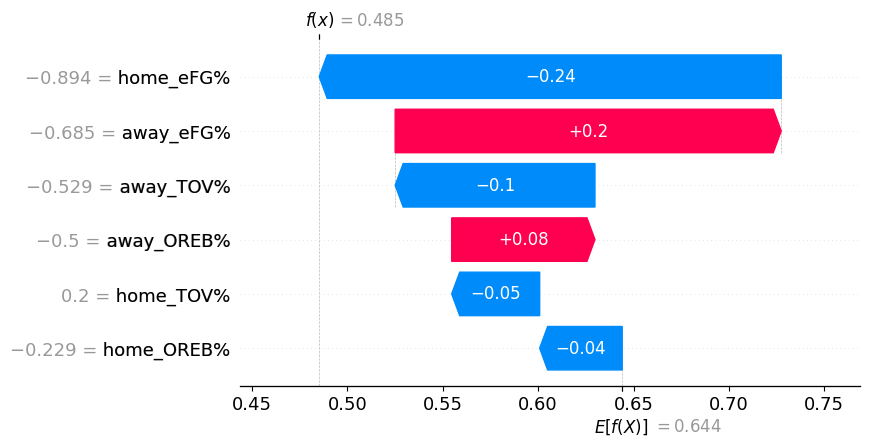

In [40]:
ind = 9

print(f"Index max in test set : {X_test.shape[0]}")
shap.plots.waterfall(sv_prob[ind,:,1])

### Global

In [41]:
# creating SV object with all X_train in the background
shap_pred_explainer = shap.Explainer(model.predict, X_train)
# Fitting on X_test
sv_pred = shap_pred_explainer(X_test)

<Axes: xlabel='SHAP value (impact on model output)'>

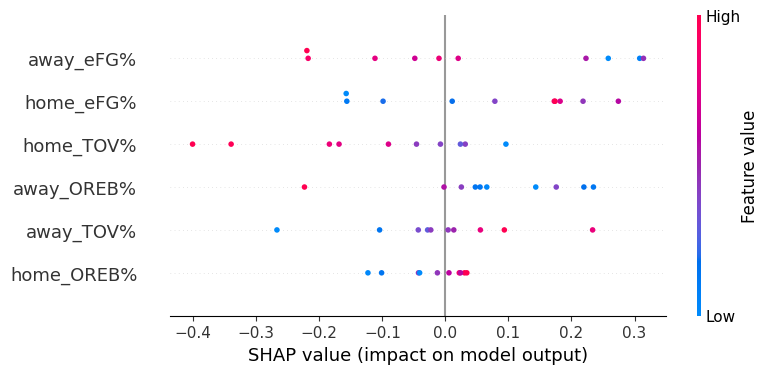

In [42]:
shap.plots.beeswarm(sv_pred, max_display=13, show=False)

### Query

In [43]:
X_query.shape

(21, 6)

In [44]:
shap_query_df = shap_query(df =gdf,
                           X_query = X_query,
                           shap_explainer= shap_prob_explainer,
                           team=team,
                           season = season,
                           league = league)
shap_query_df.head()

,home_team,away_team,team_eFG%,opponent_eFG%,team_OREB%,opponent_OREB%,team_TOV%,opponent_TOV%
0,Villeneuve d'Ascq LM,Spar Girona,0.088677,0.236134,-0.047148,0.040744,-0.000648,0.038196
1,Spar Girona,Villeneuve d'Ascq LM,-0.381115,-0.061469,-0.061166,0.046388,0.010805,0.090599
2,Villeneuve d'Ascq LM,Serco UNI Gyor,0.305207,-0.247872,-0.028001,-0.016175,0.138697,0.061366
3,Perfumerias Avenida,Villeneuve d'Ascq LM,-0.097948,-0.319368,-0.086520,0.068283,0.011862,0.071958
4,Villeneuve d'Ascq LM,Cukurova Basketbol Mersin,-0.275773,-0.117019,-0.096236,0.091829,-0.012891,-0.126662


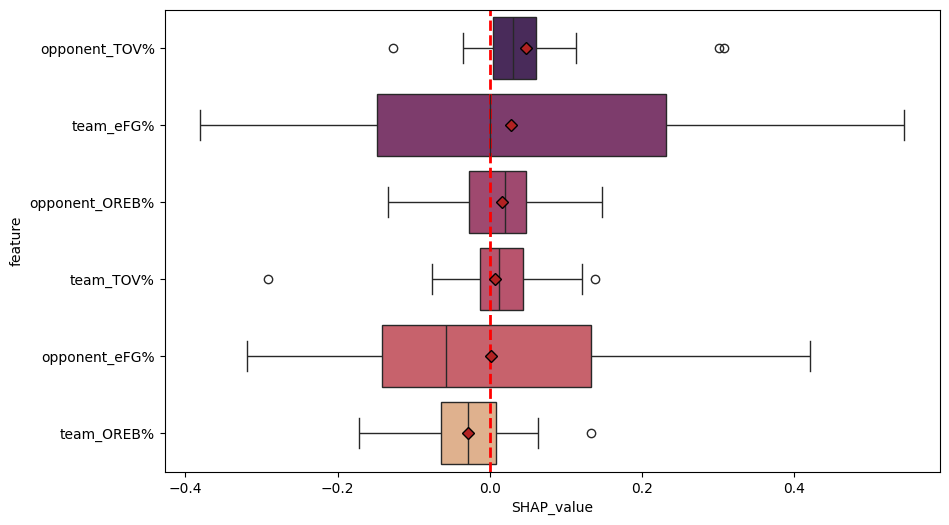

In [45]:
threshold = 0.0001

fig, ax = plt.subplots(1,1,figsize = (10,6))
info_cols = ['game_id','home_team', 'away_team'] if 'game_id' in shap_query_df.columns else ['home_team', 'away_team']
team_expl_cols = shap_query_df.drop(columns = info_cols).columns
id = pd.MultiIndex.from_product([shap_query_df[team_expl_cols].index, shap_query_df[team_expl_cols].columns], names=('gameday', 'feature'))
t_df = pd.DataFrame(np.array(shap_query_df[team_expl_cols]).reshape(len(shap_query_df[team_expl_cols])*len(shap_query_df[team_expl_cols].columns),1), index = id).rename(columns={0:'SHAP_value'})
t_df.reset_index(inplace= True)
feat_mask = (t_df.groupby('feature').mean()['SHAP_value'].abs() > threshold).rename('Threshold_filter')
mean_shap = t_df.groupby('feature').mean()['SHAP_value'].rename('Mean_SHAP_value')
t_df = t_df.merge(feat_mask, left_on = 'feature', right_index = True)
t_df = t_df.merge(mean_shap, left_on = 'feature', right_index = True)
t_df.sort_values(by = 'Mean_SHAP_value', ascending = False, inplace=True)
meanpointprops = dict(marker='D', markeredgecolor='black',
                    markerfacecolor='firebrick')
sns.boxplot(data = t_df[t_df['Threshold_filter']], x = 'SHAP_value', y = 'feature', hue = 'Mean_SHAP_value', palette = 'flare', legend = False, ax=ax, showmeans = True, meanprops = meanpointprops)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.close()

In [46]:
spider_plot_df = t_df[['feature','SHAP_value']].groupby('feature').mean()
spider_plot_df

,SHAP_value
feature,
opponent_OREB%,0.016301
opponent_TOV%,0.048129
opponent_eFG%,0.001271
team_OREB%,-0.028396
team_TOV%,0.007696
team_eFG%,0.028476


(<Figure size 1000x1000 with 1 Axes>,
 <PolarAxes: title={'center': 'Spider Chart'}>)

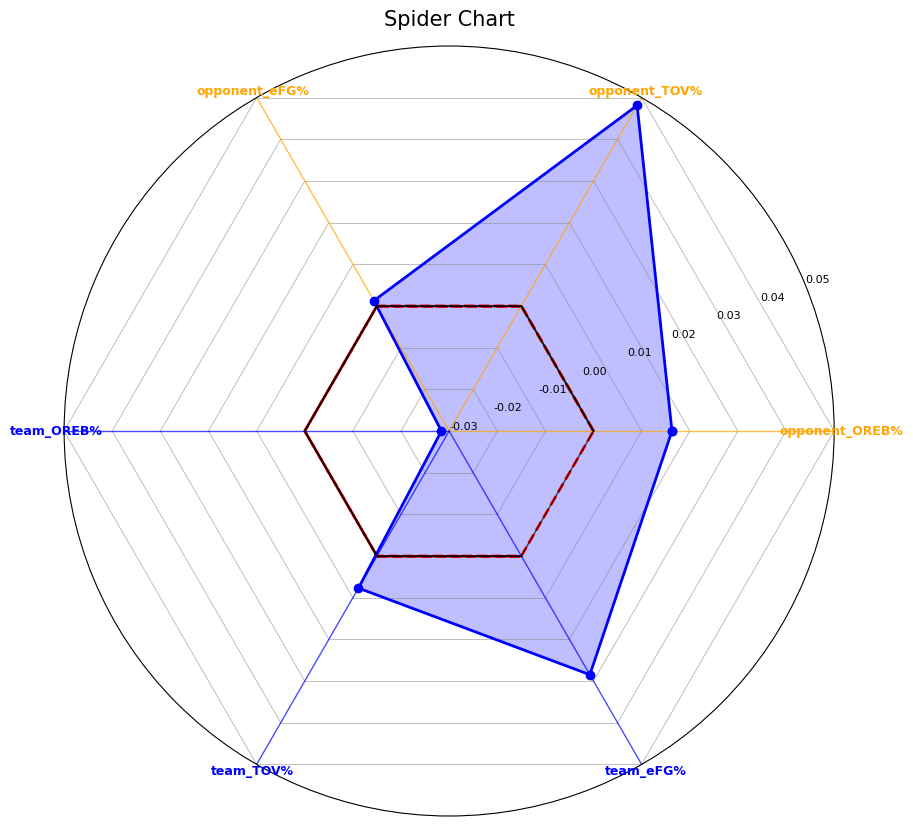

In [48]:
create_spider_chart(
    categories=spider_plot_df.index,
    values=spider_plot_df['SHAP_value'],
    min_value=-0.03,
    max_value=0.05,
    graduation_levels=8,
    highlight_level=0,
    category_colors=['blue' if feat[:4] == 'team' else 'orange' for feat in spider_plot_df.index]
    
)